## 1. Intro to Rydberg dynamics


Now that we have learned all the basic control parameters for neutral-atom analog quantum computers, we can start looking at running programs and studying interesting dynamics for problem solving. This is the theme of this chapter.

### 1a. Dynamics for a single atom

In this section we will look more formally at the effect of the Rabi drive on a single atom, and then multiple atoms. 

We saw in Chapter I that we control this Rabi drive with the Rabi waveform $\Omega (t)$. If $\phi = 0$, and $\Delta = 0$, and we only have one atom, then the Hamiltonian of the problem simplifies to just:

$$
H = \frac{\Omega(t)}{2} \left(|g\rangle\langle r| +|r\rangle\langle g|\right) \equiv \frac{\Omega(t)}{2} \sigma_x
$$

where we represent the state flipping operator as $\sigma_x \equiv \left(|g\rangle\langle r| +|r\rangle\langle g|\right)$, i.e., using the corresponding real-valued Pauli matrix.

### 1b. Rabi oscillations

**Rabi oscillations** is a canonical phenomenon in quantum dynamics. Given a single two-level system - aka, a qubit - started in the $|0\rangle$ of the computational '$z$-basis', and a driving field around an axis not parallel with this $z$, we observe oscillations in the qubit state. 

Here is a diagram with the corresponding mathematical solutions:

<img src="assets/Rabi_diagram.png" width="500" height="auto" />

The simplest scenario occurs in the presence of a constant field in a direction perpendicular to $z$, say $x$ as in the figure above. As time $t$ advances, the state of our qubit would oscillate sinusoidially between
the initial state $|g\rangle$ and the excited state $|r\rangle$. 

For neutral-atom systems, this oscillation can be easily verified by measuring a $z$-observable such as the occupation of the Rydberg state:

$$
<\hat{n}> = \langle \psi (t) | \hat{n} | \psi (t) \rangle = \sin^2 \frac{\Omega}{2}t
$$

where $ \hat{n} = 1 * |r \rangle \langle r | + 0 * | g \rangle \langle g |$ and the state $|\psi \rangle$ is as in the figure above. The result of such evolution can be depicted as in the figure below.


<img src="assets/Rabi_oscillation.png" width="500" height="auto" />

#### Example: Single atom dynamics

Let's work through how to deploy this single atom example on Bloqade. Start with imports for this section.

In [71]:
from bloqade import start, cast, load, save
import os
import matplotlib.pyplot as plt
from bokeh.io import output_notebook
from bloqade.atom_arrangement import ListOfLocations
from bloqade import  piecewise_linear, cast
import numpy as np
output_notebook()

if not os.path.isdir("data"):
    os.mkdir("data")

Loading BokehJS ...

Now, we will need a single atom

In [2]:
atom_coordinate=ListOfLocations([(0,0)])
atom_coordinate.show()

And a simple Rabi waveform, as flat as possible

In [3]:
ramp_time=0.06
rabi_ampl=15
detuning_value=0.0
run_time=1.0

durations = [ramp_time, run_time, ramp_time]
values=[0, rabi_ampl, rabi_ampl, 0]
waveform_rabi = piecewise_linear(durations, values)
waveform_rabi.show()

> note: our quantum hardware constraints demand that the wave form for the Rabi amplitude requires ramping up and down from zero at the ends of the protocol. The Rabi oscillations result above is still valid for this time-dependent protocol, except that the accumulated phase $\Omega t$ as function of time must be exchanged for the integrated frequency amplitude $\int_0^t d\tau \Omega(\tau)$. We leave proving this as an exercise to the reader.

Now it is time to learn some more Bloqade tricks. We want to evolve our quantum state under the same Hamiltonian for multiple times of different durations, in order to visualize the state's time evolution. Running via `rydberg_h()` like last chapter is possible, but cumbersome. Here we will learn how to batch tasks and use variables to streamline our workflow.

While `rydberg_h()` operated simply by ingesting a register made of  a `ListOfPositions` and `piecewise_linear` and `piecewise_constant` waveforms, we will now take a different path that will require generating a program and including atom and waevform objects in a concatenated way. Here is how it goes.

We beging by using the `start` object to create our `register`. Then we concatenate a register using a `.` syntax and the `add_position` method:

In [4]:
register1 = ( start.add_position((0, 0)))

Now we continue concatenating waveform instructions to create a full `rabi_oscillations_program`. First, we include a control for a uniformly distributed (independent of atom index, as in the actual hardware) Rabi amplitude:  

In [6]:
durations = cast(["ramp_time", "run_time", "ramp_time"])

register_rabi = (
    register1
    .rydberg.rabi.amplitude.uniform.piecewise_linear(durations=durations, values=[0, "rabi_ampl", "rabi_ampl", 0])
)

Note we are using here our old `piecewise_linear` method, but taking the opportunity to include variables `"ramp_time"`, `"run_time"`, and `"rabi_ampl"` which are not predetermined before we start running the program. This makes the program really a "function", which can be automatically called for different values of ramp times, running times, and strengths of the Rabi amplitude!

For the sake of completeness, we can complete the `rabi_oscillations_program` with a uniform (instead of locally varying) constant detuning $\Delta$ field

In [7]:
rabi_oscillations_program = (
    register_rabi
    .detuning.uniform.constant(duration=sum(durations), value="detuning_value")
)

Of course, you could perform this full concatenation in a single strike, which may be easier once you get used to the syntax:

In [8]:
durations = cast(["ramp_time", "run_time", "ramp_time"])

rabi_oscillations_program = (
    start.add_position((0, 0))
    .rydberg.rabi.amplitude.uniform.piecewise_linear(durations=durations, values=[0, "rabi_ampl", "rabi_ampl", 0])
    .detuning.uniform.constant(duration=sum(durations), value="detuning_value")
)

Now we are ready to run. We create a list `run_times` of 101 time instances at which we want to evaluate the time evolution of our qubit within $3 \mu s$, assign specific values for variables with a unique desired value such as "ramp_time", `"rabi_ampl"` and `"detuning_value"`, and `batch_assign` the `"run_time"` lengths from our list `run_times`.

This will create a `rabi_oscillation_job`, that will contain tasks with different time evolutions as one batch.  

In [13]:
run_times = np.linspace(0, 3, 101)

ramp_time=0.06
rabi_ampl=15
detuning_value=0.0

rabi_oscillation_job = rabi_oscillations_program.assign(
    ramp_time=ramp_time, rabi_ampl=rabi_ampl, detuning_value=detuning_value
).batch_assign(run_time=run_times)

Again, while this looks more evolved than a simple `rydberg_h`, the flexibility and conciseness for running multiple tasks at once more than compensates for that!

We are almost ready submit this batch job to the emulator, specifying the number of times each task (i.e., each time step) is measured. Usually we call this the number of "shots" for a given task. In this case we use 100. The more shots we have, the better accuracy in our measurements (usually this measurement accuracy goes as $1/\sqrt{N}$ where $N$ is the chosen number of shots). If we pick too few, will not be able to plot the evolution properly.

One last subtletly: because we will have multiple measurement data, it is good practice to save and collect that information in specific data files. Here is how we do all of this:

In [11]:
emu_filename = os.path.join(os.path.abspath(""), "data", "rabi-emulation.json")

if not os.path.isfile(emu_filename):
    emu_batch = rabi_oscillation_job.bloqade.python().run(100)
    save(emu_batch, emu_filename)

We wrap this process with a quick plotting script that loads the data, averages the different shot outcomes for each oscillation point, and joins all results as function of time in a plot

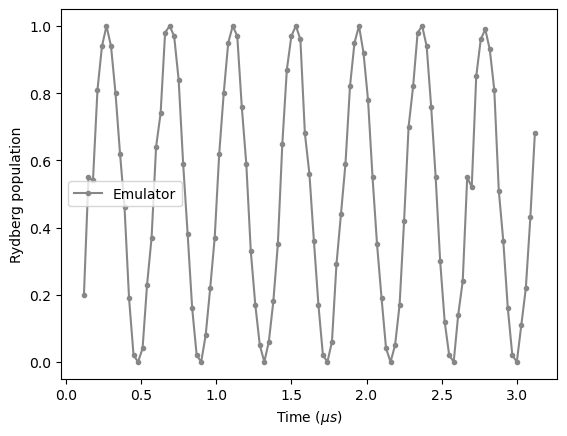

In [14]:
emu_batch = load(emu_filename)

#hardware_report = hardware_batch.report()
emulator_report = emu_batch.report()

times = emulator_report.list_param("run_time")
for i in range (len(times)):
    times[i]=times[i]+ 2*ramp_time
density = [1 - ele.mean() for ele in emulator_report.bitstrings()]
plt.plot(times, density, color="#878787", marker=".", label="Emulator")

plt.xlabel("Time ($\mu s$)")
plt.ylabel("Rydberg occupation")
plt.legend()
plt.show()

Rabi oscillations! The finer we probe the time axis and the more statistics we build with higher shot counts, the closer to a sine this figure will be. But above everything, the program above can be readily deployed in actual quantum hardware so you can consider testing our qubit callibrations by yourself!